# Group Project, Maschinelle Intelligenz und Gesellschaft, SoSe20
**Group Members:**  
* Laura Lucaj, 03727901  
* Maheep Tripathi, 03729663  
* Malina Mekhail, 03729429  
* Nikolas Hars, 03695406  
    

In [36]:
#pip install responsibly

---
## Introduction

The recent events of the Black Lives Matter movement bring into the spotlgiht the fraught issues of racial discrimination in policing. Amazon and Microsoft both pledged a year long moratorium on the use of facial-recognition technology in policing in order to mitigate issues of fairness. Tech companies that use AI and ML to build policing tools to claim improve fairer and more efficient use of police resources. with products that predict recidivism or probability of occurence of crime using tools such as the COMPAS score. It is very important to make sure AI systems are as fair as possible when used in delicate contexts that determine the future life of an individual.
In order to check for fairness in this analysis, we look at a data set of COMPAS recidivism scores and examine it as per various fairness criteria. We select 2 sensitive attributes for our analysis - ethnic background and gender.

We begin by simply examining the ROC curves for both these sensitive attributes. The ROC Curve is an evaluation metrics that is used to check and visualise the classification by showing the trade-off between sensitivity (TPR) and specificity (1-FPR). 

---
### Used Modules

In [37]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Useful
from sklearn.metrics import (roc_curve, 
                             auc, 
                             precision_recall_curve, 
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter

# Final Model
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Responsibly
from responsibly.fairness.metrics import (distplot_by,
                                          independence_binary,
                                          separation_binary,
                                          sufficiency_binary,
                                          independence_score,
                                          separation_score,
                                          sufficiency_score,
                                          report_binary,
                                          plot_roc_by_attr,
                                          roc_curve_by_attr)

from responsibly.fairness.interventions.threshold import (find_thresholds,
                                                          find_thresholds_by_attr,
                                                          plot_fpt_tpr,
                                                          plot_roc_curves,
                                                          plot_roc_curves_thresholds,
                                                          plot_costs,
                                                          plot_thresholds,
                                                         _titlify)

from criteria import CriteriaData
from build_dataset import build_dataset

---
### Read Dataset and Preprocess It

In [38]:
# Raw Dataset for further use
df_raw = pd.read_csv("compas_rec.csv")

# Dataset that can and should be used further
data = df_raw
data['Female'] = 1-(data['Sex'].astype('category')).cat.codes
data['Felony Type'] = (data['Degree of Conviction'].astype('category')).cat.codes
data["Ethnicity Number"] = (data['Race'].astype('category')).cat.codes
df = data.drop(columns=["Name","Sex","Race","Degree of Conviction"])
df["COMPAS Score"] /= 10
df.head()

# Define possible X and definite y in pandas dataframe format
X = df.drop(columns=["Recidivism"])
y = df.loc[:,"Recidivism"]

# Globally needed lists to split and categorize Datasets
glob_ethn_labels = ["African-American","Asian","Caucasian","Hispanic","Native American","Others"]
glob_gender_labels = ["Male", "Female"]
split_categories = ["Female", "Ethnicity Number"]
colors = ['b','y','r','g','c','m']

X.head()

,Age,Juvenile Felonies,Juvenile Misdemeanors,Juvenile Others,Previous Convictions,Days in Jail,COMPAS Score,Female,Felony Type,Ethnicity Number
0,69,0,0,0,0,1,0.1,0,0,5
1,34,0,0,0,0,97,0.3,0,0,0
2,24,0,0,1,4,2,0.4,0,0,0
3,44,0,0,0,0,322,0.1,0,1,5
4,41,0,0,0,14,7,0.6,0,0,2


---
### Methods to use on a list of dataframes

In [39]:
def split_set(df,category):
    """
    Method splits the dataset in multiple datasets that contain only 
    one value of the specified category  
    """
    datasets = []
    if category == "Gender":
        num_sets = 2
        category_int = 0
    elif category == "Ethnicity":
        num_sets = 6
        category_int = 1
    else:
        return None
    
    # Find Category to split the dataset
    category = split_categories[category_int]
    
    for i in range(0,num_sets):
        temp_bool = df[category] == i
        datasets.append(df[temp_bool])
    return datasets

def drop_multiple_df(dataframes,col="Recidivism"):
    """
    Drop Method for a list of dataframes: e.g. get X
    """
    X = []
    for i in range(0,len(dataframes)):
        temp = dataframes[i].drop(columns=[col]).to_numpy()
        X.append(temp)
    return X

def loc_multiple_df(dataframes,col="Recidivism"):
    """
    Loc Method for a list of dataframes (get one column): e.g. get y
    """
    y = []
    for i in range(0,len(dataframes)):
        y.append(dataframes[i].loc[:,col].to_numpy())
    return y

In [40]:
datasets = split_set(df,"Ethnicity") # Splits the dataframe according to the specified Sensitive Attribute
X_list = drop_multiple_df(datasets) # Creates a list of X
y_list = loc_multiple_df(datasets) # Creates a list of y

datasets = split_set(df,"Gender")
X_list_Gender = drop_multiple_df(datasets)
y_list_Gender = loc_multiple_df(datasets)

## Start of the Analysis:

### Methods needed

In [41]:
def compas_pred(score_orig,threshold):
    """Predicts the outcome of the compas classifier"""
    score = np.zeros(np.shape(score_orig))
    for i in range(0,len(score)):
        if score_orig[i] >= threshold:
            score[i] = 1
        else:
            score[i] = 0
    return score

def plot_roc_and_return_cm_list(X_list,Y_list, display=True):
    """
    Method plots the ROC if display==True and returns tpr,fpr and cm_list
    """
    list_size = len(X_list)
    if list_size == 2:
        labels = glob_gender_labels
        attr = "Gender"
    elif list_size == 6:
        labels = glob_ethn_labels
        attr = "Ethnicity"
    else:
        return None
    if display:
        plt.figure(figsize=[8,8])
    
    fpr_list = []
    tpr_list = []
    thr = []
    cm_list = []
    
    for elem in range(0,len(X_list)):
    
        # ROC Curve computation
        fpr, tpr, thresholds = roc_curve(Y_list[elem],X_list[elem][:,6])
        
        if thresholds[0] == 2:
            thresholds[0] = 1.1
        cm = []
        for th in thresholds:
            cm.append(confusion_matrix(Y_list[elem], compas_pred(X_list[elem][:,6],th)))
        cm_list.append(cm)
    
    
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thr.append(thresholds)
                
        # AUC computation
        auc_train = auc(fpr, tpr)

        # ROC Curve Plot
        if display:
            plt.plot(fpr, tpr, label='{}: (area = {:.3f})'.format(labels[elem],auc_train))
            
    if display:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve by Attribute: {}'.format(attr))
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return fpr_list, tpr_list, thr, cm_list


def plot_fpr_fnr_vs_thr(fpr,tpr,thr,attr = 'all'):
    """
    Method plots the fpr and fnr against the thresholds
    """
    if attr == "all":
        attr = range(0,len(fpr))
        
    if max(attr) > len(fpr):
        return None
    fnr = [1-i for i in tpr]
    
    plt.figure(figsize=[8,8])
    fn_style = '-'
    fp_style = '--'
    if len(fpr) == 2:
        labels = glob_gender_labels
        sens_attr = "Gender"
    elif len(fpr) == 6:
        labels = glob_ethn_labels
        sens_attr = "Ethnicity"
    else:
        return None
    
    for elem in attr:
        fn_col = fn_style + colors[elem]
        fp_col = fp_style + colors[elem]
        plt.plot(thr[elem],fpr[elem],fp_col, label='{} - FPR '.format(labels[elem]))
        plt.plot(thr[elem],fnr[elem],fn_col, label='{} - FNR '.format(labels[elem]))
    plt.xlabel('Thresholds')
    plt.ylabel('Rate')
    plt.title('FPR-FNR Curves by {}'.format(sens_attr))
    plt.legend(loc='best')
    plt.xticks([i/10 for i in range(12)])
    #plt.xlim(0,1)
    plt.grid()
    plt.show()    
    
def plot_acceptance(cm, thr, attr = 'all',display = True):
    """
    Method plots the acceptance rate and returns 
    """
    if attr == "all":
        attr = range(0,len(cm))
        
    if max(attr) > len(cm):
        return None
    
    acc_style = '-'
    if len(cm) == 2:
        labels = glob_gender_labels
        attribute = 'Gender'
    elif len(cm) == 6:
        labels = glob_ethn_labels
        attribute = 'Ethnicity'
    else:
        return None
    
    tot_acc = []
    for elem in attr:
        acc = []
        #Get acceptance rate
        for ind in range(0,len(thr[elem])): 
            tp = cm[elem][ind][1][1]
            fp = cm[elem][ind][0][1]
            fn = cm[elem][ind][1][0]
            tn = cm[elem][ind][0][0]
            
            acc.append((tp+fp)/(tp+fp+tn+fn))
            
        tot_acc.append(acc)
        
    if display:
        # plot ppv and npv
        plt.figure(figsize=[8,8])
        for ind in range(0,len(tot_acc)):
            acc_col = acc_style + colors[ind]

            plt.plot(thr[ind], tot_acc[ind], acc_col, label='{} - Acceptance Rate '.format(labels[ind]))
            
        plt.xlabel('Threshold')
        plt.ylabel('Acceptance Rate')
        plt.title(' Acceptance rates over all thresholds, by ' + attribute)
        plt.legend(loc = 'best')
        plt.xticks([i/10 for i in range(12)])
        plt.grid()
        plt.show()

    return tot_acc
    
    
def plot_sufficiency(cm, thr, attr = 'all',display = True):
    """
    Method plots the sufficiency and returns ppv and npv
    """
    if attr == "all":
        attr = range(0,len(cm))
        
    if max(attr) > len(cm):
        return None
    
    ppv_style = '-'
    npv_style = '--'
    pos_style = ':'
    neg_style = ':'
    if len(cm) == 2:
        labels = glob_gender_labels
        attribute = 'Gender'
    elif len(cm) == 6:
        labels = glob_ethn_labels
        attribute = 'Ethnicity'
    else:
        return None
    
    tot_ppv = []
    tot_npv = []
    tot_pos = []
    tot_neg = []
    for elem in attr:
        ppv = []
        npv = []
        pos = []
        neg = []
        #Get List of ppv and npv for every threshold
        for ind in range(0,len(thr[elem])): 
            tp = cm[elem][ind][1][1]
            fp = cm[elem][ind][0][1]
            fn = cm[elem][ind][1][0]
            tn = cm[elem][ind][0][0]
            
            if tp == 0 and fp == 0:
                ppv.append(1)
            elif tp == 0:
                ppv.append(0)
            elif fp == 0:
                ppv.append(1)
            else:
                ppv.append(tp/(tp+fp))
                
            if tn == 0 and fn == 0:
                npv.append(1)
            elif tn == 0:
                npv.append(0)
            elif fn == 0:
                npv.append(1)
            else:
                npv.append(tn/(fn+tn))
            pos.append((tp+fn)/(tp+fp+tn+fn))
            neg.append((tn+fp)/(tp+fp+tn+fn))
            
        tot_pos.append(pos)
        tot_neg.append(neg)
        tot_npv.append(npv)
        tot_ppv.append(ppv)
        
    if display:
        # plot ppv and npv    
        plt.figure(figsize=[8,8])
        for ind in range(0,len(tot_ppv)):
            ppv_col = ppv_style + colors[ind]
            pos_col = pos_style + colors[ind]

            plt.plot(thr[ind], tot_ppv[ind], ppv_col, label='{} - PPV '.format(labels[ind]))
            plt.plot(thr[ind], tot_pos[ind], pos_col, label='{} - recid_rate '.format(labels[ind]))

        plt.xlabel('Threshold')
        plt.ylabel('Value')
        plt.title('PPV & Recid_rate over all thresholds, by ' + attribute)
        plt.legend(loc = 'best')
        plt.xticks([i/10 for i in range(12)])
        plt.grid()
        plt.show()

        plt.figure(figsize=[8,8])
        for ind in range(0,len(tot_ppv)):
            npv_col = npv_style + colors[ind]
            neg_col = neg_style + colors[ind]

            plt.plot(thr[ind], tot_npv[ind], npv_col, label='{} - NPV '.format(labels[ind]))
            plt.plot(thr[ind], tot_neg[ind], neg_col, label='{} - Non-recid_rate '.format(labels[ind]))

        plt.xlabel('Threshold')
        plt.ylabel('Value')
        plt.title('NPV & Non-Recid-Rate over all thresholds, by ' + attribute)
        plt.legend(loc = 'best')
        plt.xticks([i/10 for i in range(12)])
        plt.grid()
        plt.show()

    return tot_ppv,tot_npv

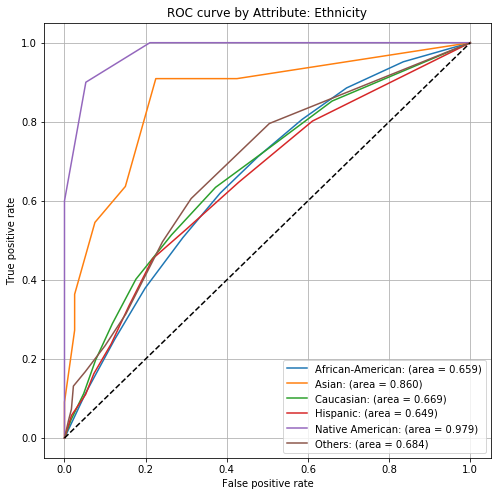

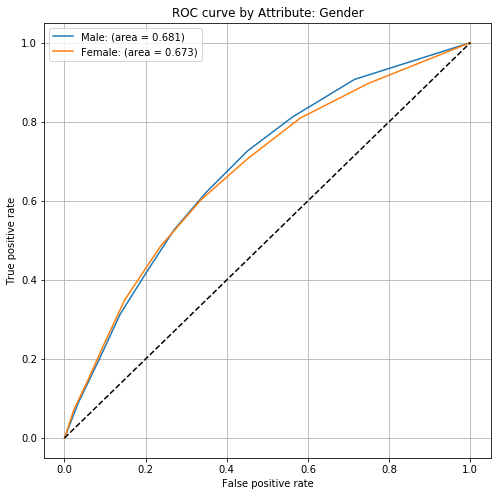

In [42]:
# Ethnicity:
fpr_eth, tpr_eth, t_eth, cm_list_eth = plot_roc_and_return_cm_list(X_list,y_list)

# Gender:
fpr_gen, tpr_gen, t_gen, cm_list_gen = plot_roc_and_return_cm_list(X_list_Gender, y_list_Gender)

### Interpretation ROC Curve

It can be observed that for the different ethnical groups the prediction's performance differs, for example, 
Whereas, when observing the classification of the other groups, which 

### Interpretation of FPR-TPR Curves by Attribute
 
The curves show the falsely predicted values as opposed to the positively predicted values. We can observe that the false positive rate of the african american ethnical group is higher, which implies that they are classified as more recidivistic than the other ethnicities. 
Moreover, it can be observed that the rates are not equal at any threshold, which is why it is not possible to take one threshold for all groups and the separations criteria is not fulfilled. Due to the bias in the dataset, the threshold cannot be used to balance out the bias. Therefore, different thresholds for every group are necessary. If one was not to use a classifier that gives different thresholds to the groups, using o.1 as a threshold would mean classifying everyone as recidivistic.

### Interpretation of ROC Curves by Attribute

The ROC curves for Caucasians and African American (and Hispanic) groups follow one another closely and show relatively poor performance. These curves lie closer to the 45-degree diagonal, the classification tend to be more random and the test is less accurate (AUC < 0.7 for all). The ROC curve of the Asian and Native American groups shows a more accurate classification. However,by checking the distribution of samples, we observed that the Native American group is undersampled and therefore that might be the cause of the shape of the curve. This does not mean that the predictions are accurate, because the lower number of samples, the least significant inferences can be made. 

In this plot, we compared the different rates  for the african american and caucasian group, as they are the ones with the highest number of samples in the dataset and therefore some significant inferences can be made. Predicting african-americans as more recidivistic, comes with a high cost in civil liberties rights, because a false positive prediction directly impacts the life of the individual, by determining an unfair future based on an inaccurate prediction, which is more severe than negatively predicting a low likelihood of recidivism. If the individual were to recommit a crime, they could always be re-arrested in the future, but someone that does not end up committing a crime and has to stay in jail because the algorithm predicted that they would have, cannot get those years of freedom back.

***
## Fairness Criteria

Checking for independence, separation and sufficiency

Already we've seen that the classifier performance is not great for ethnic groups. We now examine how well the COMPAS score performs on metrics of fairness - independence, separation and sufficiency.

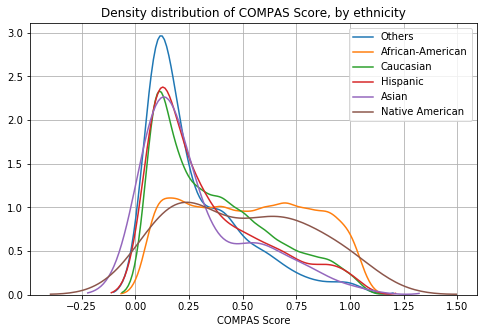

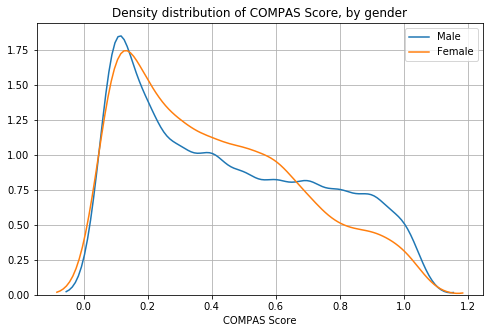

In [43]:
# Check what the distribution of COMPAS scores looks like for all 'races' 

plt.figure(figsize=[8,5])
g = distplot_by(df['COMPAS Score'], df['Ethnicity Number'], hist=False)
for g_ in g:
    handles,labels = g_.get_legend_handles_labels()
    g_.legend([glob_ethn_labels[int(i)] for i in labels])
plt.title('Density distribution of COMPAS Score, by ethnicity')
plt.xlabel('COMPAS Score')
plt.grid()
plt.show()

plt.figure(figsize=[8,5])
g = distplot_by(df['COMPAS Score'], df['Female'], hist=False)
for g_ in g:
    handles,labels = g_.get_legend_handles_labels()
    g_.legend([glob_gender_labels[int(i)] for i in labels])
plt.title('Density distribution of COMPAS Score, by gender')
plt.xlabel('COMPAS Score')
plt.grid()
plt.show()

### Observations:
Already, we can see that the distribution of the score varies depending on ethnicity. For instance, COMPAS scores for Caucasian defendants are heavily concentrated towards lower values. In contrast, the distribution of values for African-American defendants is fairly uniform.The following checks how the data (with sensitive attribute A), the COMPAS Score (R) and the predictions of recidivism (Y) perform based on formal fairness criteria. <br> 
***

This plot shows a non-parametric way to estimate the probability density function of a random variable. The lines show the estimates of the underlying distributions, which clearly is not equal for the different ethnical groups, which is determined by the different amount of samples per ethnic group present in the data set. Ideally, a good classifier should have an equal amount of samples for each group. The different amount of samples is a mirror of the structural bias present in the american society. Certain urban areas that are inhabitated by a large amount of african americans are often over-policed, the likelihood of arrest of this ethnical group is higher, also because there is less policing observing other areas, where other ethnical groups might commit just as much crime, but are not arrested because of lack of patroling in that area. 

## TASK 1
> ### 1.1 Independence - $R ⊥ A$
* Independence is satisfied when the acceptance rate ($R = 1$) of all groups are equal
* Plot acceptance rates for all possible thresholds to see if it is possible to get a classifier based on COMPAS Scores that satisfies independence

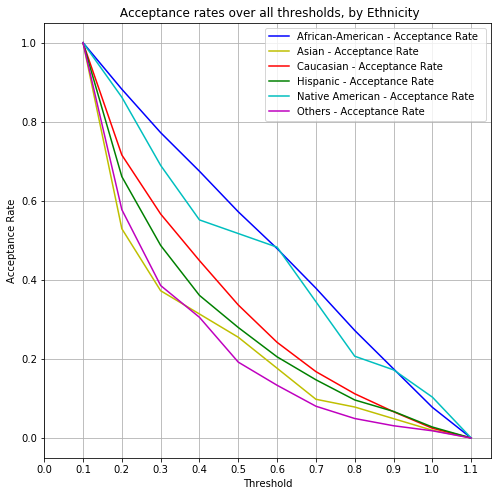

In [44]:
"""df_acceptance_rates = independence_score(df['COMPAS Score'], df['Ethnicity Number'], as_df=True).cumsum(axis=0)
df_acceptance_rates['Threshold'] = df_acceptance_rates.index.sort_values(ascending=False)
df_acceptance_rates.set_index('Threshold',inplace=True)

#g = df_acceptance_rates.plot(figsize=(8,8), drawstyle='steps')
g = df_acceptance_rates.plot(figsize=(8,8))
handles,labels = g.get_legend_handles_labels()
g.legend([glob_ethn_labels[int(i)] for i in labels])
plt.title('Acceptance rates over all thresholds, by ethnicity')
plt.xlabel('Threshold')
plt.ylabel('Acceptance Rate')
plt.xticks([i/10 for i in range(11)])
plt.grid()
plt.show()

df_acceptance_rates"""

acc = plot_acceptance(cm_list_eth, t_eth)

### Observations:

We can see from the graph that for different groups based on the sensitive attribute, the 'acceptance rate' is different for all groups over all thresholds (except 0 and 1). Independence, defined as $P( R=1 | A=a ) = P( R=1 | A=b ) \hspace{0.5cm} \forall a,b \in A$, i.e. the same acceptance rate (ideally) for every ethnic group, is therefore not satisified. 

Clearly the COMPAS score is not independent of the sensitive attribute of ethnic background and correlates with the outcome. The shape of the curve indicates the distribution of scores from 0 to 1. Looking at the different shapes of the curves it is clear that the acceptance rates are very different for the various ethnical groups. The african-american group, for instance, has the highest acceptance rates across all thresholds and their scores seem to be uniformly distributed in (0,1). This means that this group is more likely to be classified as recidivistic. In comparison, the Caucasian group have a distribution that is skewed towards lower COMPAS scores. A fair classifier, should enable everyone to have the same chances, so in this case to make it fairer different thresholds have to be established for the acceptance rates.

Independence holds only at thresholds 0 and 1 as these are the only thresholds that give the same acceptance rates for all ethnicities. However these are not viable classifiers.

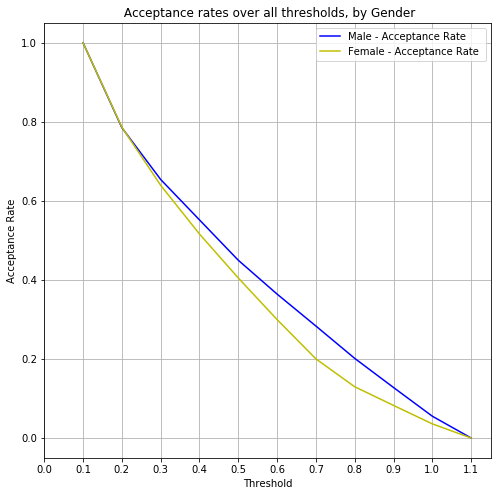

In [45]:
"""# Gender
df_acceptance_rates = independence_score(df['COMPAS Score'], df['Female'], as_df=True).cumsum(axis=0)
df_acceptance_rates['Threshold'] = df_acceptance_rates.index.sort_values(ascending=False)
df_acceptance_rates.set_index('Threshold',inplace=True)

#g = df_acceptance_rates.plot(figsize=(8,8), drawstyle='steps')
g = df_acceptance_rates.plot(figsize=(8,8))
handles,labels = g.get_legend_handles_labels()
g.legend([glob_gender_labels[int(i)] for i in labels])
plt.title('Acceptance rates over all thresholds, by gender')
plt.xlabel('Threshold')
plt.ylabel('Acceptance Rate')
plt.xticks([i/10 for i in range(11)])
plt.grid()
plt.show()

df_acceptance_rates"""

acc_gen = plot_acceptance(cm_list_gen, t_gen)

> ## 1.2 Separation - $R ⊥ A|Y$
* Separation is satisfied when the false negative rates ( FNR -> $P(R=0|Y=1)$ ) and false positive rates ( FPR -> $P(R=1|Y=0)$ ) of all groups are equal

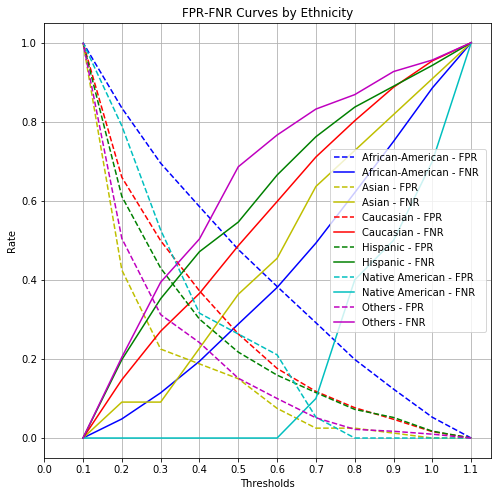

In [46]:
plot_fpr_fnr_vs_thr(fpr_eth,tpr_eth,t_eth,attr = 'all')

### Observations
In this plot we can clearly observe that the rates (FPR, FNR) are not equal for both false positives and false negatives. A false positive prediction is more costly, in these circumstances, because the freedom of an individual might directly be harmed by an inaccurate prediction. In this plot, we can observe that the African American group has the highest rate in false positive predictions and the lowest rate in false negative predictions, which again points to the unfairness of the model because the dataset is clearly disproportionately **falsely** targeting this group as more likely to re-offend in the future compared to other groups. When considering that the samples analysed by the model were unequally distributed and consisted of a high-number of African American samples. Ideally a separation-satisfying fair model should have equal false negatives and false positives rates for each group, but this imbalance shows the structural bias present in the american society being mirrored in these algorithms.

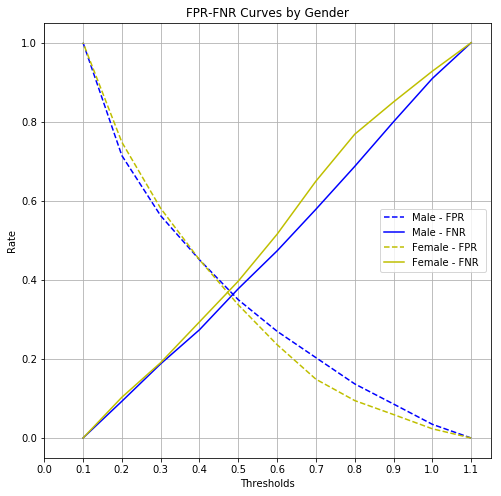

In [47]:
plot_fpr_fnr_vs_thr(fpr_gen,tpr_gen,t_gen)

> ## 1.3 Sufficiency - $Y⊥ A|R$
* Sufficiency is satisfied when the positive predictive values ( PPV or precision -> $P(Y=1|R=1)$ ) or negative predictive values (NPV -> $P(Y=0|R=0)$ for all groups are equal

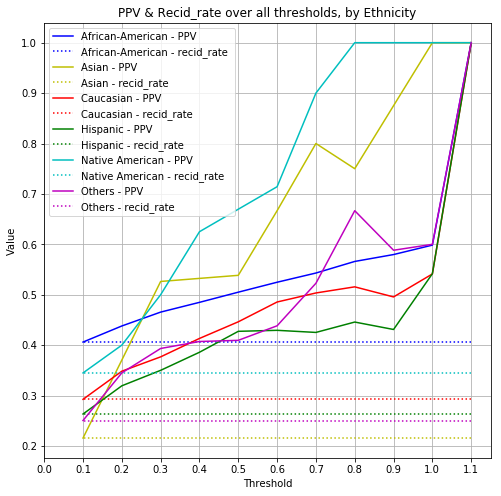

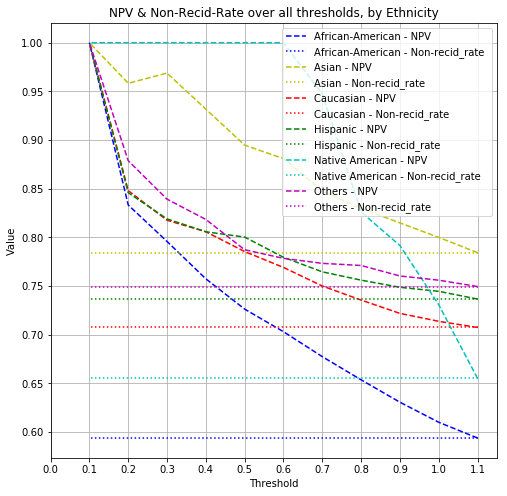

In [48]:
# Ethnicity
ppv_eth, npv_eth = plot_sufficiency(cm_list_eth,t_eth,attr = 'all')

### Observations
In general we can observe that the classifier does not provide a high dynamic range, which implies that the classifier is not good at all and it is very likely to undertake random predictions. By setting the threshold to high court, high ppv and npv can be reached. However, since the ppv count has a higher dynamic range and it is ethically more important to correctly classify positiv cases, it is better to choose a value where ppv is higher. Unfortunately, the African American group has a ppv range between approx 0,4 and 0,6. From that
we can conclude that whatever threshold is chosen, there will be around 50% falsely classified out of all positiv classified. Furthermore, this plot shows that the sample is dispoportionally classifying the African Americans as more recidivistic, which means that the samples that are fed to the model are inherently biased and could lead the classifier to determine a high correlation between the African American ethnical background and the likelihood to re-commit a crime in the future. Addtionally, Caucasians also have a small range and an even lower ppv count so there will be even more falsly positively classified people relative to the total amount of positively classified. This also gets obvious by looking at the performance of the predicted value. 
We also observed that the curve belonging to the Asian group goes slightly down between 0.7 and 0.8, which means that at 0.8 more fpv were predicted.
In general, the model is clearly not satisfying sufficiency because the sensitive characteristics are still determining different npv and ppv.

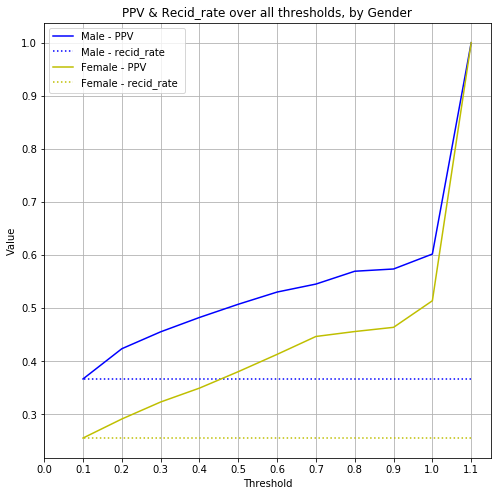

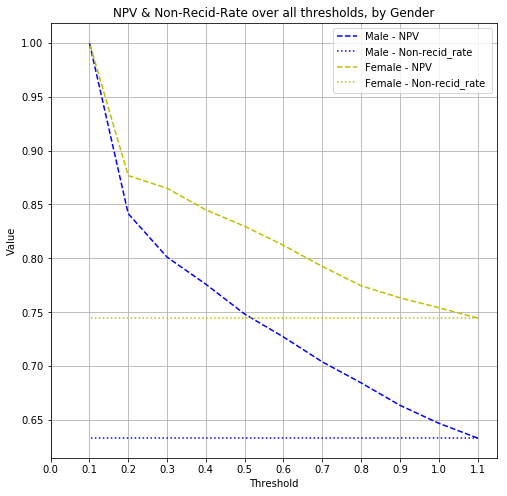

In [49]:
# Gender
ppv_gen, npv_gen = plot_sufficiency(cm_list_gen,t_gen,attr = 'all')

---
## TASK 2

The previous section shows that the COMPAS score does not satisfy any of the fairness criteria we examined it for. We attribute this unfairness to the bias in the nature of how and how much training data, per group, is collected. One can expect the nature of the sampled African Americans to be riddled with the structural racial bias against the group in reporting crime and harsher policing of African Americans. The number of African Americans sampled in this data set is disproportionately higher compared to the size of the group in the population - ideally, more training data would lead to better performance, but in this case it amplifies the error of falsely predicting recidivism among African Americans due to bias. Ideally, we should account for this societal structural bias that show up in the training data, and ensure that ethnicity plays no role in scoring the recidivism probability of an individual.  

In this task, we try to see if we can achieve any of the fairness criteria by using different thresholds for each group. 

> ## 2.1 Aligning for Independence - $R ⊥ A$


In [50]:
# Define a training and a test set
df_train, df_test = train_test_split(df, test_size=0.3, random_state=400)

# PREPARE DATA TO USE 'find_threshold' FROM 'responsibly' 
# get cdf
df_cdf = independence_score(df_train['COMPAS Score'], df_train['Ethnicity Number'], as_df=True).cumsum(axis=0)
df_cdf.columns = pd.Series(glob_ethn_labels)
df_cdf.columns = df_cdf.columns.rename('Race')
df_cdf

# get pdf
df_pdf = pd.DataFrame()
for i in range(6):
    df_subset = df_train[df['Ethnicity Number'] == i]
    df_column = pd.Series(dtype='float')
    for score in range(10):
        score = (score + 1)/10
        l_recid = df_subset[df_subset['COMPAS Score'] == score]['Recidivism'].tolist()
        try:
            performance = Counter(l_recid)[1]/float(len(l_recid))
        except:
            #performance = 'NA'
            performance = 1
        df_column[score] = performance
    df_pdf[glob_ethn_labels[i]] = df_column
df_pdf

# get totals
totals = dict(Counter(df_train['Ethnicity Number']))
for i in range(6):
    totals[glob_ethn_labels[i]] = totals.pop(i)
totals

DATA = build_dataset(totals,df_cdf, df_pdf)

C:\Users\Maheep\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Comparison of Different Criteria

* Single threshold : Same threshold for all groups that minimises cost (group unaware)
* Independence (Demographic Parity) : Thresholds allowed to vary, tries to equalise independence

#### Cost: $FP = -2*TP $

In [84]:
# COST_MATRIX = [[0, -1/3],
#                [0,  2/3]]
#[[tn, fp], [fn, tp]]
COST_MATRIX = [[0, -1/3],
               [0, 2/3]]

thresholds_data = find_thresholds(DATA['rocs'],
                                  DATA['proportions'],
                                  DATA['base_rate'],
                                  DATA['base_rates'],
                                  COST_MATRIX)
thresholds_data = dict((k, thresholds_data[k]) for k in ('single','independence'))
#print(thresholds_data['independence'])
#print(find_thresholds)
#print(thresholds_data['separation'],'\n FNR :', thresholds_data['fnr'])
#     :return: Dictionary of threshold criteria, and for each criterion:
#              thresholds, FPR and TPR by attribute and cost value.
#     fnr = FN / (TP + FN) --> separation is equal FNRs

In [88]:
def plot_roc_curves_thresholds(roc_curves, thresholds_data,
                               aucs=None,
                               title='ROC Curves by Attribute',
                               ax=None, figsize=None,
                               title_fontsize='large',
                               text_fontsize='medium'):
    """Generate the ROC curves by attribute with thresholds.

    Based on :func:`skplt.metrics.plot_roc`

    :param roc_curves: Receiver operating characteristic (ROC)
                       by attribute.
    :type roc_curves: dict
    :param thresholds_data: Thresholds by attribute from the
                            function
                            :func:`~responsibly.interventions
                            .threshold.find_thresholds`.
    :type thresholds_data: dict
    :param aucs: Area Under the ROC (AUC) by attribute.
    :type aucs: dict
    :param str title: Title of the generated plot.
    :param ax: The axes upon which to plot the curve.
               If `None`, the plot is drawn on a new set of axes.
    :param tuple figsize: Tuple denoting figure size of the plot
                          e.g. (6, 6).
    :param title_fontsize: Matplotlib-style fontsizes.
                          Use e.g. 'small', 'medium', 'large'
                          or integer-values.
    :param text_fontsize: Matplotlib-style fontsizes.
                          Use e.g. 'small', 'medium', 'large'
                          or integer-values.
    :return: The axes on which the plot was drawn.
    :rtype: :class:`matplotlib.axes.Axes`

    """

    ax = plot_roc_curves(roc_curves, aucs,
                         title, ax, figsize, title_fontsize, text_fontsize)

    MARKERS = ['o', 'x']
    colors = ['yellow','purple']
    sizes = [100, 180]
    
    for (name, data), marker, c, s in zip(thresholds_data.items(), MARKERS, colors, sizes):
        label = _titlify(name)
        if label == 'Separation' : continue
        label = 'FNR (Separation)' if label == 'FNR' else label
        ax.scatter(*zip(*data[1].values()),
                   marker=marker, color=c, s=s*2, label=label,
                   zorder=float('inf'))

    plt.legend()

    return ax

(-0.1, 1)

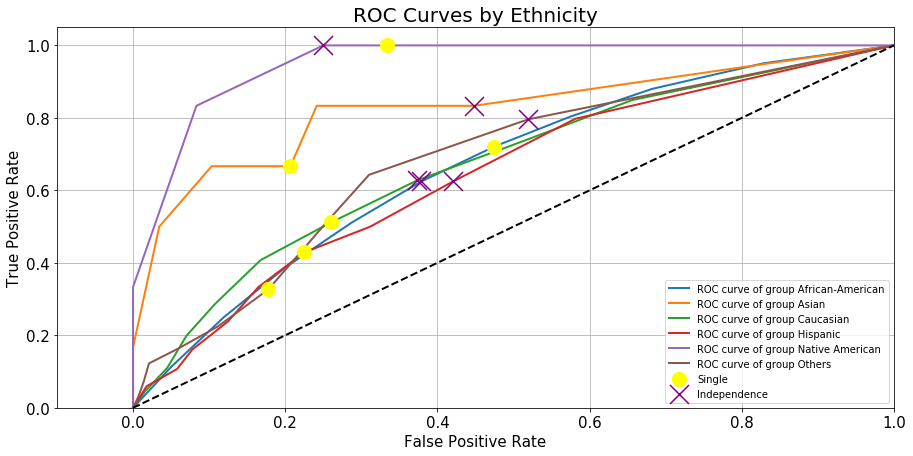

In [120]:
plot_roc_curves_thresholds(DATA['rocs'], 
                           thresholds_data,
                           title="ROC Curves by Ethnicity",
                           figsize=(15, 7),
                           title_fontsize=20, text_fontsize=15);
plt.grid()
plt.xlim(-0.1, 1)

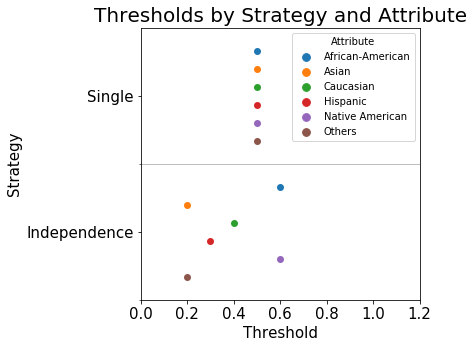

In [103]:
plot_thresholds(thresholds_data,
                xlim=(0, 1.2), figsize=(5, 5),
                title_fontsize=20, text_fontsize=15);

## Observations Task 2

Here we use the python implementation developed by Barocs et. al. for Chapter-2 of Fairness and machine learning, Limitations and Opportunities.  

The above plots show different thresholds for each group used to satisfy independence, the different thresholds are observable in the first plot.  

Again, ideally the acceptance rates should be equal among the groups, in order for independence to hold. However the implementation of independence used here introduces a relaxation and calculates thresholds for acceptance rates with the minimum distance. Best case, the thresholds should be equal. From this plot we can read that the thresholds need to be different for each group, which indicates that the model is not fair.

In [121]:
def get_cm(X_l,Y_l,th_l,datatype = "list",attr = "Ethnicity"):
    if len(X_l) != len(th_l):
        return None
    
    if attr == "Ethnicity":
        label = glob_ethn_labels
    elif attr == "Gender":
        label = glob_gender_labels
    else:
        return None
    
    cm = []
    for index in range(0,len(th_l)):
        if datatype == "list":
            cm.append(confusion_matrix(Y_l[index], compas_pred(X_l[index][:,6],th_l[index])))
        elif datatype == "dict":
            cm.append(confusion_matrix(Y_l[index], compas_pred(X_l[index][:,6],th_l[label[index]])))
    return cm

def get_single_cm(X,Y,th):
    if len(X[:,6]) != len(Y):
        return None

    return confusion_matrix(Y, compas_pred(X[:,6],th))

def get_fairness_crit(cm):
    sep = [0,0]
    suf = [0,0]
    
    # Define CM elements
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    
    # Independence
    ind = float(tp + fp) / float(tp + fp + fn + tn) 
                   
    # Seperation
    if tp == 0 and fn == 0:
        sep[0] = 1
    elif tp == 0:
        sep[0] = 0
    elif fn == 0:
        sep[0] = 1
    else:
        sep[0] = tp / (tp + fn)
        
    if fp == 0 and tn == 0:
        sep[1] = 1
    elif fp == 0:
        sep[1] = 0
    elif tn == 0:
        sep[1] = 1
    else:
        sep[1] = fp / (tn + fp)
    
    # Sufficiency
    if tp == 0 and fp == 0:
        suf[0] = 1
    elif tp == 0:
        suf[0] = 0
    elif fp == 0:
        suf[0] = 1
    else:
        suf[0] = tp / (tp + fp)
        
    if tn == 0 and fn == 0:
        suf[1] = 1
    elif tn == 0:
        suf[1] = 0
    elif fn == 0:
        suf[1] = 1
    else:
        suf[1] = tn / (tn + fn)
    
    return ind,sep,suf

def get_thresholds(metric,min_value):
    th_v = [1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    
    th_ret = []
    for single_met in metric:
        for ind in range(0,len(single_met)):
            i = 0
            if single_met[ind] <= min_value:
                th_ret.append(th_v[ind])
                i = 1
                break
        if i == 0:
            th_ret.append(0.0)
        
        #print(th_ret)
    return th_ret

def get_fairness_thresh_ind(ppv,npv,t,low=0.7):
    top = 1/low
    ret_list = []
    dev = 0
    for in_1 in range(0,len(t[0])):
        ppv_1 = ppv[0][in_1]
        if ppv_1 == 0:
            ppv_1 = 0.00001
        npv_1 = npv[0][in_1]
        if npv_1 == 0:
            npv_1 = 0.00001
        for in_2 in range(0,len(t[1])):
            ppv_2 = ppv[1][in_2]
            if ppv_2 == 0:
                ppv_2 = 0.00001
            npv_2 = npv[1][in_2]
            if npv_2 == 0:
                npv_2 = 0.00001

            if (top > ppv_1/ppv_2 >= low) and (top > npv_1/npv_2 >= low):
                dev += get_dev(ppv_1,ppv_2) + get_dev(npv_1,npv_2)
                if len(ppv) == 2:
                    ret_list.append([[dev/2],[in_1, in_2]])
                else:                    
                    for in_3 in range(0,len(t[2])):
                        ppv_3 = ppv[2][in_3]
                        if ppv_3 == 0:
                            ppv_3 = 0.00001
                        npv_3 = npv[2][in_3]
                        if npv_3 == 0:
                            npv_3 = 0.00001

                        if (top > ppv_3/ppv_2 >= low) and (top > npv_3/npv_2 >= low) and (top > ppv_1/ppv_3 >= low) and (top > npv_1/npv_3 >= low):
                            dev += get_dev(ppv_1,ppv_3) + get_dev(npv_1,npv_3)
                            dev += get_dev(ppv_2,ppv_3) + get_dev(npv_2,npv_3)
                            for in_4 in range(0,len(t[3])):
                                ppv_4 = ppv[3][in_4]
                                if ppv_4 == 0:
                                    ppv_4 = 0.00001
                                npv_4 = npv[3][in_4]
                                if npv_4 == 0:
                                    npv_4 = 0.00001

                                if (top > ppv_4/ppv_3 >= low) and (top > npv_4/npv_3 >= low) and (top > ppv_4/ppv_2 >= low) and (top > npv_4/npv_2 >= low) and (top > ppv_4/ppv_1 >= low) and (top > npv_4/npv_1 >= low):
                                    dev += get_dev(ppv_1,ppv_4) + get_dev(npv_1,npv_4)
                                    dev += get_dev(ppv_2,ppv_4) + get_dev(npv_2,npv_4)
                                    dev += get_dev(ppv_3,ppv_4) + get_dev(npv_3,npv_4)
                                    for in_5 in range(0,len(t[4])):
                                        ppv_5 = ppv[4][in_5]
                                        if ppv_5 == 0:
                                            ppv_5 = 0.00001
                                        npv_5 = npv[4][in_5]
                                        if npv_5 == 0:
                                            npv_5 = 0.00001

                                        if (top > ppv_5/ppv_4 >= low) and (top > npv_5/npv_4 >= low) and (top > ppv_5/ppv_3 >= low) and (top > npv_5/npv_3 >= low) and (top > ppv_5/ppv_2 >= low) and (top > npv_5/npv_2 >= low) and (top > ppv_5/ppv_1 >= low) and (top > npv_5/npv_1 >= low):
                                            dev += get_dev(ppv_1,ppv_5) + get_dev(npv_1,npv_5)
                                            dev += get_dev(ppv_2,ppv_5) + get_dev(npv_2,npv_5)
                                            dev += get_dev(ppv_3,ppv_5) + get_dev(npv_3,npv_5)
                                            dev += get_dev(ppv_4,ppv_5) + get_dev(npv_4,npv_5)

                                        for in_6 in range(0,len(t[5])):
                                            ppv_6 = ppv[5][in_6]
                                            if ppv_6 == 0:
                                                ppv_6 = 0.00001
                                            npv_6 = npv[5][in_6]
                                            if npv_6 == 0:
                                                npv_6 = 0.00001

                                            if (top > ppv_6/ppv_5 >= low) and (top > npv_6/npv_5 >= low) and (top > ppv_6/ppv_4 >= low) and (top > npv_6/npv_4 >= low) and (top > ppv_6/ppv_3 >= low) and (top > npv_6/npv_3 >= low) and (top > ppv_6/ppv_2 >= low) and (top > npv_6/npv_2 >= low) and (top > ppv_6/ppv_1 >= low) and (top > npv_6/npv_1 >= low):
                                                dev += get_dev(ppv_1,ppv_6) + get_dev(npv_1,npv_6)
                                                dev += get_dev(ppv_2,ppv_6) + get_dev(npv_2,npv_6)
                                                dev += get_dev(ppv_3,ppv_6) + get_dev(npv_3,npv_6)
                                                dev += get_dev(ppv_4,ppv_6) + get_dev(npv_4,npv_6)
                                                dev += get_dev(ppv_5,ppv_6) + get_dev(npv_5,npv_6)

                                                ret_list.append(([[dev/25],
                                                                  [in_1, in_2, in_3, in_4, in_5, in_6],
                                                                  [t[0][in_1],t[1][in_2],t[2][in_3],t[3][in_4],t[4][in_5],t[5][in_6]],
                                                                  [ppv_1,ppv_2,ppv_3,ppv_4,ppv_5,ppv_6],
                                                                  [npv_1,npv_2,npv_3,npv_4,npv_5,npv_6]
                                                                 ]))
                                                dev = 0
    if ret_list is not None: # Sort
        for ind in range(0,len(ret_list) - 1):
            for j in range(ind,len(ret_list)):
                if ret_list[ind][0] > ret_list[j][0]:
                    temp = ret_list[ind]
                    ret_list[ind] = ret_list[j]
                    ret_list[j] = temp
    return ret_list

def get_dev(metr_1,metr_2):
    return abs(1-metr_2/metr_1)

In [122]:
# Get cm for independence thresholds:

# Training
# Test set
train_datasets = split_set(df_train,"Ethnicity") # Splits the dataframe
X_list_tr = drop_multiple_df(train_datasets) # Creates a list of X
y_list_tr = loc_multiple_df(train_datasets) # Creates a list of y
cm_ind = get_cm(X_list_tr, y_list_tr, thresholds_data['independence'][0],"dict") 

independence = []
seperation = []
sufficiency = []
for cm in cm_ind:
    ind, sep, suf = get_fairness_crit(cm)
    independence.append(ind)
    seperation.append(sep)
    sufficiency.append(suf)
    
suf = np.array(sufficiency)
sep = np.array(seperation)

train = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
             index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
             columns=glob_ethn_labels)

# Test set
test_datasets = split_set(df_test,"Ethnicity") # Splits the dataframe according to their ethnicity(1) or gender(0)
X_list_te = drop_multiple_df(test_datasets) # Creates a list of X
y_list_te = loc_multiple_df(test_datasets) # Creates a list of y

cm_ind = get_cm(X_list_te, y_list_te, thresholds_data['independence'][0],"dict") 

independence = []
seperation = []
sufficiency = []
for cm in cm_ind:
    ind, sep, suf = get_fairness_crit(cm)
    independence.append(ind)
    seperation.append(sep)
    sufficiency.append(suf)
    
suf = np.array(sufficiency)
sep = np.array(seperation)

test = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
             index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
             columns=glob_ethn_labels)

In [123]:
print("Training:\n")
print(train.to_latex())

Training:

\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.479857 &  0.514286 &   0.447466 &  0.476499 &         0.500000 &  0.589610 \\
Seperation: tpr  &          0.624727 &  0.833333 &   0.627841 &  0.625000 &         1.000000 &  0.795918 \\
Seperation: fpr  &          0.379049 &  0.448276 &   0.373767 &  0.420935 &         0.250000 &  0.519164 \\
Sufficiency: ppv &          0.534204 &  0.277778 &   0.406998 &  0.357143 &         0.666667 &  0.343612 \\
Sufficiency: npv &          0.703959 &  0.941176 &   0.804623 &  0.804954 &         1.000000 &  0.873418 \\
\bottomrule
\end{tabular}



In [124]:
print("Testing:\n")
print(test.to_latex())

Testing:

\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.477562 &  0.562500 &   0.452096 &  0.514286 &         0.454545 &  0.549383 \\
Seperation: tpr  &          0.606419 &  1.000000 &   0.648829 &  0.711864 &         1.000000 &  0.794872 \\
Seperation: fpr  &          0.392897 &  0.363636 &   0.368421 &  0.451613 &         0.142857 &  0.471545 \\
Sufficiency: ppv &          0.503506 &  0.555556 &   0.428256 &  0.333333 &         0.800000 &  0.348315 \\
Sufficiency: npv &          0.701282 &  1.000000 &   0.808743 &  0.857143 &         1.000000 &  0.890411 \\
\bottomrule
\end{tabular}



In [125]:
# Quite Fair Threshold
ths_fair = thresholds_data['independence'][0],"dict"

## Observation
Theoretically in formal mathematical terms, independence and sufficiency can not both hold together given that the sensitive attribute ethnical background and the outcome (recidivism) are not independent, which is the case in our analysis.
These Thresholds look like they are not completely fair but if you consider a soft margin for every metric all of the criteria can nearly hold. 


In [126]:
fpr, tpr, t, cm_list = plot_roc_and_return_cm_list(X_list_tr,y_list_tr, display=False)

ppv, npv = plot_sufficiency(cm_list,t,attr = 'all', display = False)
low = 0.8

suf_th_list = get_fairness_thresh_ind(ppv,npv,t,low)[:20]
if suf_th_list:
    #print(suf_th_list[0])
    th_suf = suf_th_list[0][2]
    """for i in range(0,len(th_suf)):
        th_suf[i] = t[0][th_suf[i]]"""
    print("Thresholds: ", th_suf)

    # Training
    cm_ind = get_cm(X_list_tr, y_list_tr, th_suf) 

    independence = []
    seperation = []
    sufficiency = []
    for index in range(0,len(cm_ind)):
        ind, sep, suf = get_fairness_crit(cm_ind[index])
        independence.append(ind)
        sufficiency.append(suf)
        seperation.append(sep)
        
    suf = np.array(sufficiency)
    sep = np.array(seperation)

    train = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
                 index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
                 columns=glob_ethn_labels)

    # Test
    cm_ind = get_cm(X_list_te, y_list_te, th_suf) 

    independence = []
    seperation = []
    sufficiency = []
    for cm in cm_ind:
        ind, sep, suf = get_fairness_crit(cm)
        independence.append(ind)
        seperation.append(sep) 
        sufficiency.append(suf)

    suf = np.array(sufficiency)
    sep = np.array(seperation)

    test = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
                 index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
                 columns=glob_ethn_labels)
else:
    print("No Match for Sufficiency")


Thresholds:  [0.2, 0.5, 0.4, 0.5, 0.2, 0.4]


In [127]:
print("Training:")
print(train.to_latex())

Training:
\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.878544 &  0.285714 &   0.447466 &  0.280389 &         0.888889 &  0.324675 \\
Seperation: tpr  &          0.950545 &  0.666667 &   0.627841 &  0.428571 &         1.000000 &  0.520408 \\
Seperation: fpr  &          0.828441 &  0.206897 &   0.373767 &  0.224944 &         0.833333 &  0.257840 \\
Sufficiency: ppv &          0.443954 &  0.400000 &   0.406998 &  0.416185 &         0.375000 &  0.408000 \\
Sufficiency: npv &          0.832924 &  0.920000 &   0.804623 &  0.783784 &         1.000000 &  0.819231 \\
\bottomrule
\end{tabular}



In [128]:
print("Testing:")
print(test.to_latex())

Testing:
\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.890824 &  0.187500 &   0.452096 &  0.277551 &         0.818182 &  0.259259 \\
Seperation: tpr  &          0.954392 &  0.600000 &   0.648829 &  0.525424 &         1.000000 &  0.435897 \\
Seperation: fpr  &          0.849057 &  0.000000 &   0.368421 &  0.198925 &         0.714286 &  0.203252 \\
Sufficiency: ppv &          0.424812 &  1.000000 &   0.428256 &  0.455882 &         0.444444 &  0.404762 \\
Sufficiency: npv &          0.834356 &  0.846154 &   0.808743 &  0.841808 &         1.000000 &  0.816667 \\
\bottomrule
\end{tabular}



# Observation of sufficiency table

From this tables we can understand that sufficiency does not hold for a hard margin. Trying to achieve equal ppv and npv for all groups is not possible, which is why we used a function that considers values in the same range, which means that the function tries to divide all the ppv with each other. By plotting these values in the test and train set we can see that the distance of thresholds differs - some are close while others are rather far. However, sufficiency can hold, if the relation between all ppvs and npvs is smaller than 0,56 which means that some npvs or ppvs are up to 50% different to each other. This points to an unfair model, as the nvps and ppvs should ideally be alike. 

In [129]:
low = 0.6
sep_th_list = get_fairness_thresh_ind(tpr,fpr,t,low)[:20]
#print(tpr)
#print(sep_th_list)
if sep_th_list:
#     for elem in sep_th_list:
#         print("Deviation: {}\nThresholds: {}\n".format(elem[0],elem[2]))
    th_sep = sep_th_list[4][2]
    print(th_sep)

    # Training
    cm_ind = get_cm(X_list_tr, y_list_tr, th_sep) 

    independence = []
    seperation = []
    sufficiency = []
    for cm in cm_ind:
        ind, sep, suf = get_fairness_crit(cm)
        independence.append(ind)
        sufficiency.append(suf)
        seperation.append(sep)

    suf = np.array(sufficiency)
    sep = np.array(seperation)

    train = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
                 index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
                 columns=glob_ethn_labels)

    # Test
    cm_ind = get_cm(X_list_te, y_list_te, th_sep) 

    independence = []
    seperation = []
    sufficiency = []
    for cm in cm_ind:
        ind, sep, suf = get_fairness_crit(cm)
        independence.append(ind)
        seperation.append(sep)
        sufficiency.append(suf)

    suf = np.array(sufficiency)
    sep = np.array(seperation)

    test = pd.DataFrame(data=[independence,sep[:,0],sep[:,1],suf[:,0],suf[:,1]], 
                 index=['Independence', 'Seperation: tpr', 'Seperation: fpr','Sufficiency: ppv', 'Sufficiency: npv'], 
                 columns=glob_ethn_labels)
else:
    print("No Match for Seperation")


[0.4, 0.2, 0.3, 0.2, 0.2, 0.2]


In [130]:
print("Training:\n")
print(train.to_latex())

Training:

\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.668756 &  0.514286 &   0.563659 &  0.640194 &         0.888889 &  0.589610 \\
Seperation: tpr  &          0.803636 &  0.833333 &   0.724432 &  0.797619 &         1.000000 &  0.795918 \\
Seperation: fpr  &          0.574899 &  0.448276 &   0.497969 &  0.581292 &         0.833333 &  0.519164 \\
Sufficiency: ppv &          0.493083 &  0.277778 &   0.372807 &  0.339241 &         0.375000 &  0.343612 \\
Sufficiency: npv &          0.756757 &  0.941176 &   0.816808 &  0.846847 &         1.000000 &  0.873418 \\
\bottomrule
\end{tabular}



In [131]:
print("Testing:\n")
print(test.to_latex())

Testing:

\begin{tabular}{lrrrrrr}
\toprule
{} &  African-American &     Asian &  Caucasian &  Hispanic &  Native American &    Others \\
\midrule
Independence     &          0.688547 &  0.562500 &   0.573852 &  0.714286 &         0.818182 &  0.549383 \\
Seperation: tpr  &          0.810811 &  1.000000 &   0.742475 &  0.813559 &         1.000000 &  0.794872 \\
Seperation: fpr  &          0.608213 &  0.363636 &   0.502134 &  0.682796 &         0.714286 &  0.471545 \\
Sufficiency: ppv &          0.466926 &  0.555556 &   0.386087 &  0.274286 &         0.444444 &  0.348315 \\
Sufficiency: npv &          0.759140 &  1.000000 &   0.819672 &  0.842857 &         1.000000 &  0.890411 \\
\bottomrule
\end{tabular}



## Observations for separation
Could hold for the trivial cases (thresholds 0.1 and 1.1) but these are not valid classifiers.

This table shows that if you introduce a soft margin, then separation could hold within this margin.

---
## Task 3

In [122]:
def categorize_set_race(X,y):
    i = 0
    pos_list = [0,0,0,0,0,0]
    neg_list = [0,0,0,0,0,0]
    for index, row in X.iterrows():
        if y.iloc[i] == 1:
            pos_list[row['Ethnicity Number'].astype(int)] += 1
        else:
            neg_list[row['Ethnicity Number'].astype(int)] += 1
        i += 1
    return pos_list, neg_list

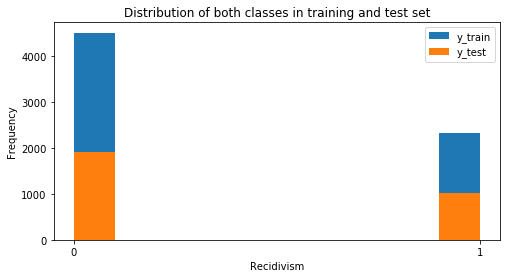

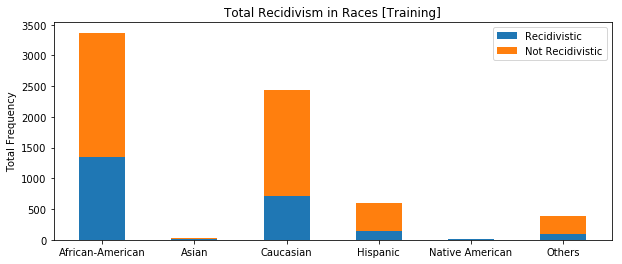

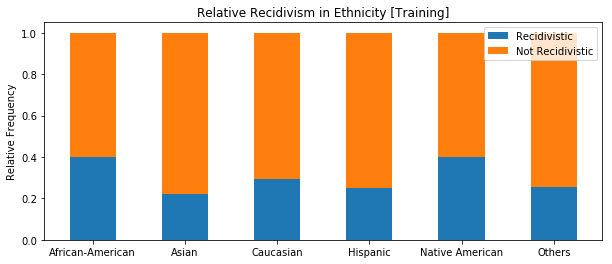

In [164]:
# creating training and test set using sklearn
X_3 = X.drop(columns=["COMPAS Score"])
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.3, random_state=50)

# plot showing the distribution of the classes (recidivism - yes or no) for the subsets
plt.figure(figsize=[8,4])
plt.hist(y_train, label='y_train')
plt.hist(y_test, label='y_test')
plt.xticks([0, 1])
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Recidivism')
plt.title("Distribution of both classes in training and test set")
plt.show()

# Get sorted counts
pos_train, neg_train = categorize_set_race(X_train,y_train)

width_1 = 0.5
indexes = np.array([0,1,2,3,4,5])

# Getting Histogram
# Training Total
plt.figure(figsize=[10,4])

p1 = plt.bar(x = indexes,height = pos_train, width=width_1)
p2 = plt.bar(x = indexes,height = neg_train, width=width_1,
             bottom=pos_train)

plt.ylabel('Total Frequency')
plt.title('Total Recidivism in Races [Training]')
plt.xticks(indexes, glob_ethn_labels)
plt.legend((p1[0], p2[0]), ('Recidivistic', 'Not Recidivistic'))
plt.show()

# Training relative
plt.figure(figsize=[10,4])

for i in range(0,6):
    a = pos_train[i]
    pos_train[i] /= (pos_train[i] + neg_train[i])
    neg_train[i] /= (a + neg_train[i])

p1 = plt.bar(x = indexes,height = pos_train, width=width_1)
p2 = plt.bar(x = indexes,height = neg_train, width=width_1,
             bottom=pos_train)

plt.ylabel('Relative Frequency')
plt.title('Relative Recidivism in Ethnicity [Training]')
plt.xticks(indexes, glob_ethn_labels)
plt.legend((p1[0], p2[0]), ('Recidivistic', 'Not Recidivistic'))
plt.show()

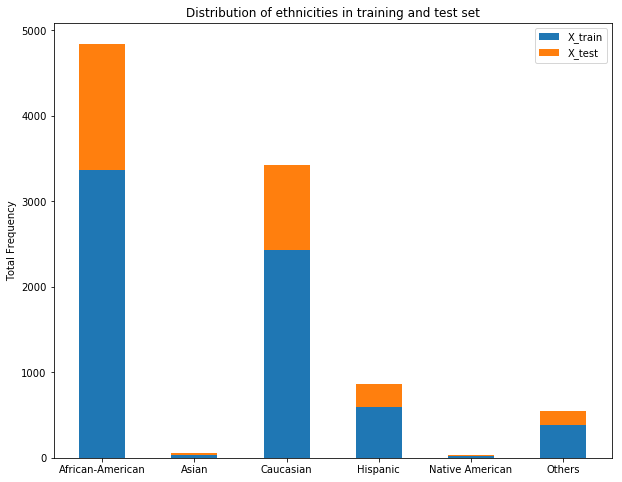

In [165]:
# Get sorted counts
pos_train, neg_train = categorize_set_race(X_train,y_train)
pos_test, neg_test = categorize_set_race(X_test,y_test)

# Getting Histogram
# Training Total
plt.figure(figsize=[10,8])
h1 = [0,0,0,0,0,0]
h2 = [0,0,0,0,0,0]
for i in range(0,len(pos_train)):
    h1[i] = pos_train[i]+neg_train[i]
    h2[i] = pos_test[i]+neg_test[i]
    
p1 = plt.bar(x = indexes,height = h1, width=width_1)
p2 = plt.bar(x = indexes,height = h2, width=width_1,
             bottom=h1)

plt.ylabel('Total Frequency')
plt.title('Distribution of ethnicities in training and test set')
plt.xticks(indexes, glob_ethn_labels)
plt.legend((p1[0], p2[0]), ('X_train', 'X_test'))
plt.show()

The first plot shows that the dataset is better at predicting non-recidivism (0) than recifivism (1) because it is largely trained on non reconvicts The second plot shows a disproportional amount of Afrian Americans and Caucasians, the predictions tend to be biased as the algoritms tends to predict better on these ethnical groups, therefore, the model is more likley to classify african americans as recidivistic as not enough data is collected on other ethnic groups.

In [167]:
# parameters to optimize (by trial and error)
## starting with the default options to get a general idea of the performance 

md= 1 # max depth
mss= 2 # min samples split
mln= 2 # max leaf nodes

dct = DecisionTreeClassifier( max_depth=md, min_samples_split=mss, max_leaf_nodes=mln, criterion='gini')
dct.fit(X_train,y_train)

y_pred = dct.predict(X_test)

In [168]:
# AUC (Area Under Curve) validation method chosen for binary classification problems

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)

print("Accuracy of the default parameters: ", roc_auc)

Accuracy of the default parameters:  0.5


In [169]:
# trying out a different function to measure the quality of a split
dct = DecisionTreeClassifier( criterion = "entropy")
dct.fit(X_train, y_train)

y_pred = dct.predict(X_test)

# testing the accuracy 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)

print("Accuracy of the default parameters: {:.5f}".format(roc_auc))

## highly decreased it, therefore: sticking with Gini and measuring the impurity instead of measuring of the information gain 

Accuracy of the default parameters: 0.57134


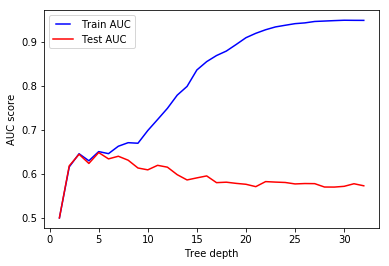

Optimal value for tree depth:  [5]


In [170]:
# trying to optimize the max depth of the tree (md)

## looping through a range of max depth parameters 

md_opt = np.linspace(1, 32, 32, endpoint = True) # testing a depth ranging from 1-32 

train_results = []
test_results = []

for max_depth in md_opt: 
  dct = DecisionTreeClassifier( max_depth = max_depth)
  dct.fit(X_train, y_train)

  train_pred = dct.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  train_results.append(roc_auc) # adding the auc score to the train results array 

  y_pred = dct.predict(X_test)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  test_results.append(roc_auc) # adding the auc score of the test to the test results array

## plotting the results 
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(md_opt, train_results, "b", label="Train AUC")
line2, = plt.plot(md_opt, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

# Train AUC overfits with larger depth values (more than a depth of 4) since it fails to predict new data while perfectly predicting the train data
md_result = np.where(test_results == np.amax(test_results))
print("Optimal value for tree depth: ", md_result[0] + 1) # at position 3 means 4, wuups.
md = min(md_result[0]) + 1

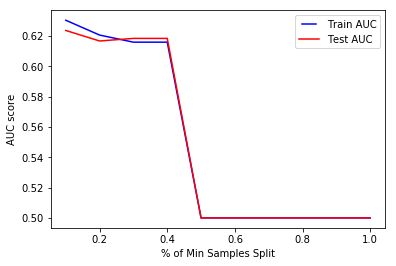

In [171]:
# trying to optimize the min samples split (mss) (can vary from at least 1, at most considering all samples at each node)
# the bigger, the more samples the tree needs to consider at each node

## varying the parameter from 10 - 100% of the samples 

mss_opt = np.linspace(0.1, 1, 10, endpoint = True)
#mss_opt = range(2,11)
train_results = []
test_results = []

for min_samples_split in mss_opt: 
  dct = DecisionTreeClassifier( max_depth = md, min_samples_split = min_samples_split)
  dct.fit(X_train, y_train)

  train_pred = dct.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  train_results.append(roc_auc) # adding the auc score to the train results array 

  y_pred = dct.predict(X_test)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  test_results.append(roc_auc) # adding the auc score of the test to the test results array

# plotting the results

line1, = plt.plot(mss_opt, train_results, "b", label="Train AUC")
line2, = plt.plot(mss_opt, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("% of Min Samples Split")
plt.show()


# to avoid underfitting, not more than 40% of all samples should be included at each node
# it looks like it is enough to consider only around 10% (which would still not achieve good AUC scores)
# the less min sample split the better, otherwise: underfitting
# 10% from the test set would mean to consider around 29 samples at each node

In [172]:
# trying out the model

dct_opt = DecisionTreeClassifier( max_depth= md, min_samples_split=2)
dct_opt.fit(X_train,y_train)

y_pred = dct_opt.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)

print("Accuracy of the md and mss optimized parameters: {:.5f}".format(roc_auc))

# already improved the accuracy a little bit 
# mss doesn't matter much, since only a depth of 4 makes sense (in avoiding overfitting)
# so probably, it also makes no sense to change the min_samples_leaf 

Accuracy of the md and mss optimized parameters: 0.64879


In [173]:
# Number of Samples 
# We can see that African - Americans aver oversampled 
df['Ethnicity Number'].value_counts()

0    4844
2    3429
3     862
5     547
1      51
4      29
Name: Ethnicity Number, dtype: int64

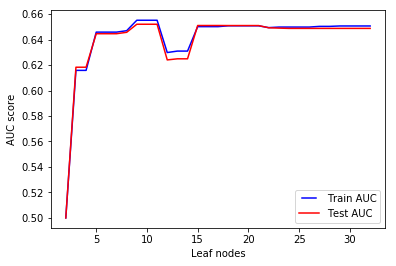

Optimal value for leaf nodes:  [ 9 10 11]


In [174]:
# trying to optimize the max leaf nodes (mln), would mean to include only the best nodes

mln_opt = np.linspace(2, 32, 32, endpoint = True, dtype = int) # testing leaf nodes int ranging from 2-32 
train_results = []
test_results = []

for max_leaf_nodes in mln_opt: 
  dct = DecisionTreeClassifier( max_depth = md, max_leaf_nodes = max_leaf_nodes) #max_depth= 4, min_samples_split=2,
  dct.fit(X_train, y_train)

  train_pred = dct.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  train_results.append(roc_auc) # adding the auc score to the train results array 

  y_pred = dct.predict(X_test)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  test_results.append(roc_auc) # adding the auc score of the test to the test results array

## plotting the results 
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(mln_opt, train_results, "b", label="Train AUC")
line2, = plt.plot(mln_opt, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Leaf nodes")
plt.show()

# either putting 2 or 5 nodes gives the best accuracy 
mln_result = np.where(test_results == np.amax(test_results))
print("Optimal value for leaf nodes: ", mln_result[0] + 1)
mln = min(mln_result[0]) + 1

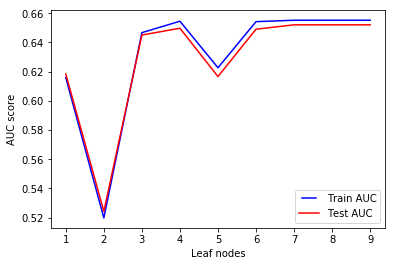

Optimal value for max features:  7


In [176]:
# trying to optimize the max features (mf), the number of features to consider when looking for the best split

mf_opt = np.linspace(1, 9, 9, endpoint = True, dtype = int) # testing features int ranging from 1-9 (columns of the data set)
train_results = []
test_results = []

for max_features in mf_opt: 
  dct = DecisionTreeClassifier(max_depth = md, min_samples_split=mss, max_leaf_nodes = mln, max_features = max_features) 
  dct.fit(X_train, y_train)

  train_pred = dct.predict(X_train)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  train_results.append(roc_auc) # adding the auc score to the train results array 

  y_pred = dct.predict(X_test)

  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  test_results.append(roc_auc) # adding the auc score of the test to the test results array

## plotting the results 
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(mf_opt, train_results, "b", label="Train AUC")
line2, = plt.plot(mf_opt, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Leaf nodes")
plt.show()

# either putting 6 or 8 features gives the best model
mf_result = np.where(test_results == np.amax(test_results))
print("Optimal value for max features: ", mf_result[0][0] + 1) # at position 3 means 4, wuups.
mf = min(mf_result[0]) + 1

In [178]:
# trying out the model

dct_opt = DecisionTreeClassifier( max_depth= 4, min_samples_split=2, max_leaf_nodes = 12, max_features = 8)
dct_opt.fit(X_train,y_train)

y_pred = dct_opt.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)

print("Accuracy of the final optimized parameters: {:.5f}".format(roc_auc))

Accuracy of the final optimized parameters: 0.62322


In [179]:
# trying out the model using only the training data set by performing a stratified k-fold

from sklearn.model_selection import StratifiedKFold

ns = 10

kf = StratifiedKFold(n_splits=ns, shuffle=True)

acc_val = np.zeros(ns)

for i, (train_index, val_index) in enumerate(kf.split(X_train,y_train)):
    
    dct_opt.fit(X.iloc[train_index,:],y.iloc[train_index])
    
    acc_val[i] = dct_opt.score(X.iloc[val_index,:],y.iloc[val_index])
    
print('Accuracy of the Classifier Model: {:.5f}'.format(np.mean(acc_val)))

Accuracy of the Classifier Model: 0.68594


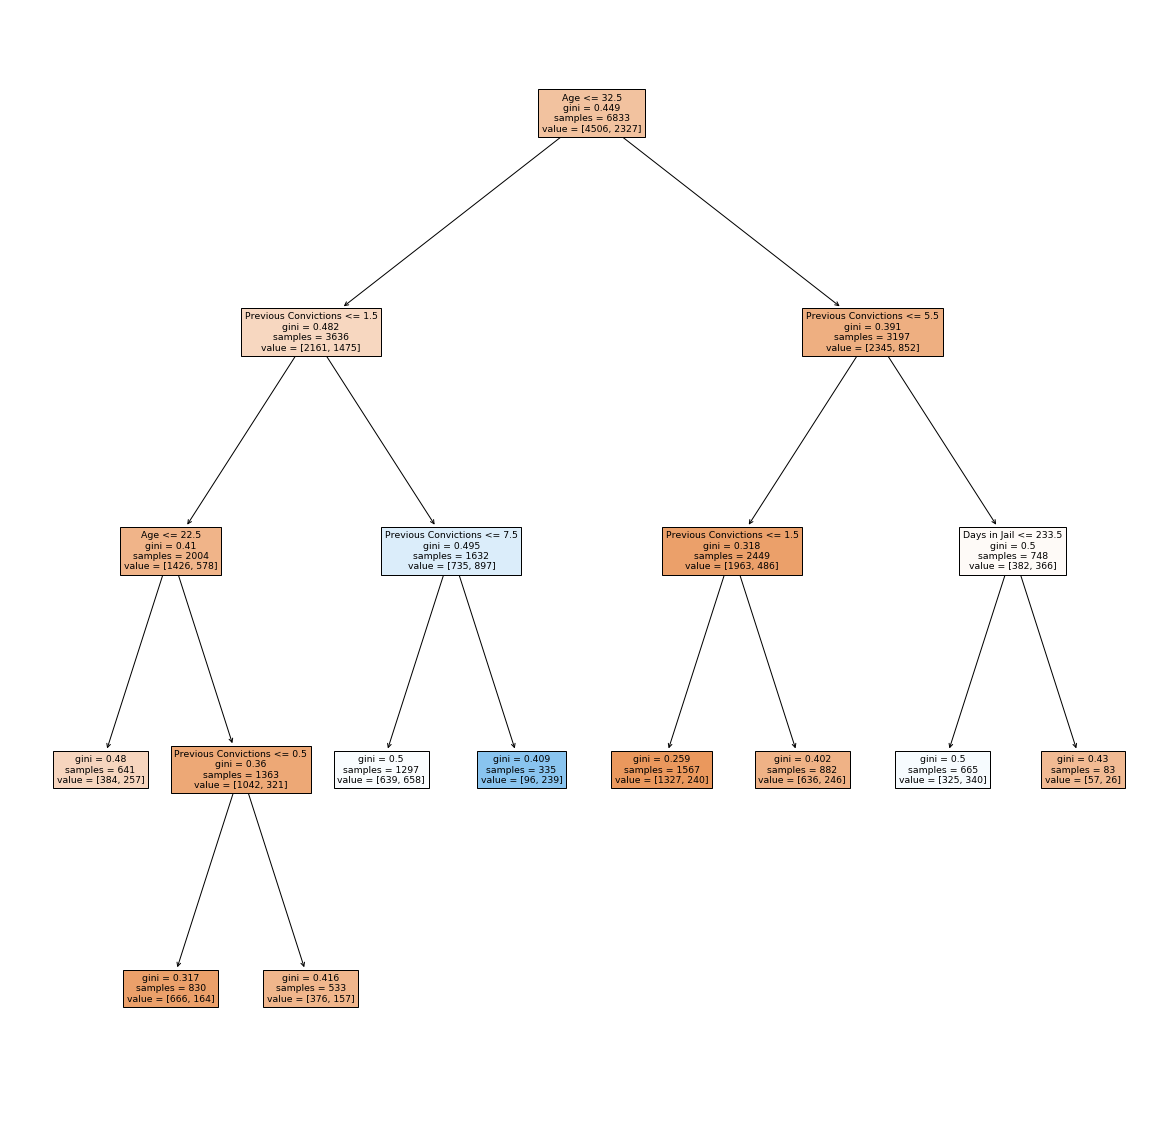

In [180]:
# the final model tree

dct_final = DecisionTreeClassifier(max_depth=md, min_samples_split=mss, max_features=mf, max_leaf_nodes=mln)
dct_final.fit(X_train, y_train)
"""random_state=42, """

# plot the tree
plt.figure(figsize=[20,20])
plot_tree(dct_final, filled=True, feature_names=X_train.columns)
plt.show()

In [181]:
# using the test set to test the final tree model

print("Accuracy of the final model with test set: {:.5f}".format(dct_final.score(X_test, y_test)))

Accuracy of the final model with test set: 0.67771


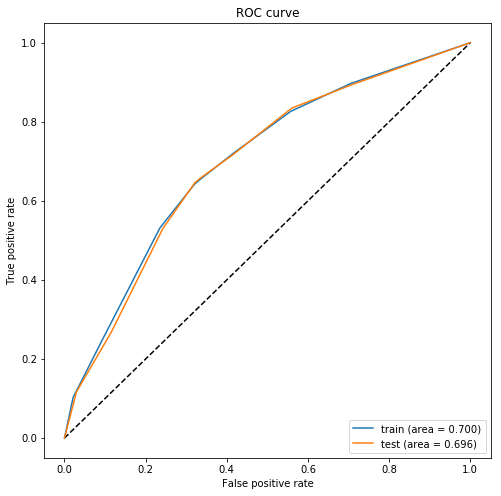

In [182]:
# ROC curve

fpr_train, tpr_train, thresholds = roc_curve(y_train,dct_final.predict_proba(X_train)[:,1])
fpr_test, tpr_test, thresholds = roc_curve(y_test,dct_final.predict_proba(X_test)[:,1])

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=[8,8])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='train (area = {:.3f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='test (area = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [183]:
# Ethnicity
X_test_3 = X_test.to_numpy()
Y_test_3 = y_test.to_numpy()
n,d = np.shape(X_test)

Y_test_new = []
X_test_new = []
for i in range(0,6):
    X_test_new.append(np.zeros((n,d)))


for ethn in range(0,6):
    Y_test_new.append(Y_test_3)
    for i in range(0,n):
        X_test_new[ethn][i,:] = X_test_3[i]
        X_test_new[ethn][i,7] = ethn
        
"""for i in range(0,6):
    print(X_test_new[i][1,:])"""

MIUG_score = []
for i in range(0,6):
    MIUG_score.append(dct_final.predict_proba(X_test_new[i])[:,1])
    
    
"""for i in range(0,6):
    print(MIUG_score[i][0])
#print(MIUG_score[5])"""



[47.  0.  0.  0.  0. 62.  0.  0.  5.]
[47.  0.  0.  0.  0. 62.  0.  1.  5.]
[47.  0.  0.  0.  0. 62.  0.  2.  5.]
[47.  0.  0.  0.  0. 62.  0.  3.  5.]
[47.  0.  0.  0.  0. 62.  0.  4.  5.]
[47.  0.  0.  0.  0. 62.  0.  5.  5.]
0.15315890236119975
0.15315890236119975
0.15315890236119975
0.15315890236119975
0.15315890236119975
0.15315890236119975


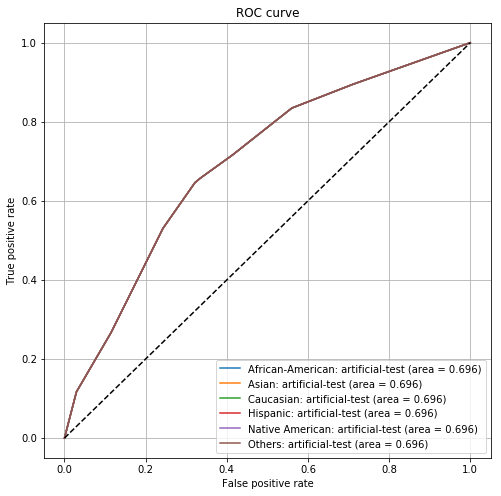

In [184]:
labels = ["African-American","Asian","Caucasian","Hispanic","Native American","Others"]

plt.figure(figsize=[8,8])
for ethn in range(0,6):
    fpr_test, tpr_test, thresholds = roc_curve(Y_test_new[ethn],dct_final.predict_proba(X_test_new[ethn])[:,1])

    auc_test = auc(fpr_test, tpr_test)
    
    plt.plot(fpr_test, tpr_test, label='{}: artificial-test (area = {:.3f})'.format(labels[ethn],auc_test))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

## Observations

Because of the difficulties with using the COMPAS score as a classifier, we decided use a decision tree as a binary classifier, because we had experience with it and it seemed to work well with the COMPAS dataset in allowing us to make some useful inferences.

For instance, we are able to see exactly which of the features are used to classify a defendant as recidivistic and therefore, we can make sure to observe that the sensitive attributes such as ethnical background or gender are not determining the prediction of the likelihood to re-commit a crime in the future. We modified the tree many times in order to make our model as fair as possible, as we wanted to exclude the sensitive attributes of gender and ethnic background for being a discriminative attribute in the decision-making context of the algorithm. Moreover, we checked the tree for fairness with gender and ethnic background as the sensitive attributes, and the tree seems to be fair for ethnic background as the likelihood of recidivism of the defendants doesn't depend on this attribute. However, we still did not manage to completely erase the bias for gender.

We modified the code many times, by defining different random states that would give us results that tried to exclude gender and ethnic background in the predictions. However, the classifier seems to be slightly more discriminatory towards women, which still makes it an unfair model. Hence, considering such inaccurate classification performance, we are very aware of the danger of using this model in such delicate contexts that impact the future life of an individual. It is unacceptable to consider that these algorithms might ruin someone’s future based on an inaccurate prediction. In conclusion, it is still not fair because it slightly discriminates one group based on gender, which is a sensitive attribute that people do not choose and it is unacceptable to discriminate on this basis. Before it gets deployed in such contexts, fairness must be improved and assured, which is mainly depending on the data samples that are fed to the algorithm.

This ROC curve shows that all ethnical groups have the same AUC (Area Under the Curve), which means that the ethnic background is not a decisive factor in the predictions about the individual's likelihood to re-commit a crime.

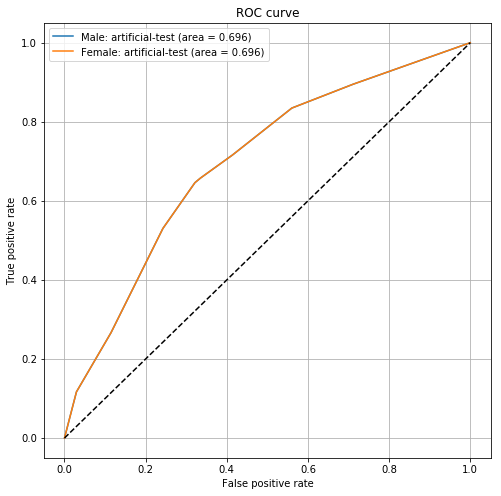

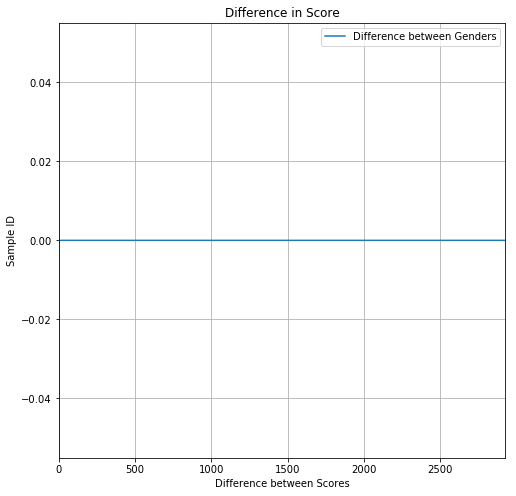

In [190]:
# Gender
X_test_Gender = X_test.to_numpy()
Y_test_Gender = y_test.to_numpy()
n,d = np.shape(X_test)

Y_test_Gender_list = []
X_test_Gender_list = []
for i in range(0,2):
    X_test_Gender_list.append(np.zeros((n,d)))
    
for gender in range(0,2):
    Y_test_Gender_list.append(Y_test_Gender)
    for i in range(0,n):
        X_test_Gender_list[gender][i,:] = X_test_Gender[i]
        X_test_Gender_list[gender][i,6] = gender
        
"""for i in range(0,2):
    print(X_test_Gender_list[i][1,:])"""

MIUG_score = []
for i in range(0,2):
    MIUG_score.append(dct_final.predict_proba(X_test_Gender_list[i])[:,1])
    
    
"""for j in range(0,50):
    for i in range(0,2):
        print(MIUG_score[i][j])
#print(MIUG_score[5])"""

# Plot
labels = ["Male","Female"]

plt.figure(figsize=[8,8])
for gender in range(0,len(labels)):
    fpr_test, tpr_test, thresholds = roc_curve(Y_test_Gender_list[gender],dct_final.predict_proba(X_test_Gender_list[gender])[:,1])

    auc_test = auc(fpr_test, tpr_test)
    
    plt.plot(fpr_test, tpr_test, label='{}: artificial-test (area = {:.3f})'.format(labels[gender],auc_test))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize=[8,8])
x = range(0,len(MIUG_score[gender]))
plt.plot(x,MIUG_score[0]-MIUG_score[1],label="Difference between Genders")
plt.xlabel('Difference between Scores')
plt.ylabel('Sample ID')
plt.title('Difference in Score')
plt.legend(loc='best')
plt.xlim([min(x), max(x)])
plt.grid()
plt.show()